In [975]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style ("white")
import numpy as np

ROOT = "/Users/rafaelfrade/arquivos/desenv/lse/anc_hiv_scheduling/data"

CONTROL = "#F95700FF"
TREATED = "#00A4CCFF"
palette_anc = [CONTROL, TREATED]
order=["control","treated"]

SOURCE_WT_FORMS = "Source: intervention forms"
SOURCE_REG = "Source: Facilities' registry book (Gov. of Mozambique)"

SIZE_REG_BOOK = "n = 3389(Control) 3109 (Treated)"

ROOT = "/Users/rafaelfrade/arquivos/desenv/lse/anc_hiv_scheduling/data"

cleaned_files_path = f"{ROOT}/anc/csv_cleaned"
CLEANED_DATA_PATH = f"{ROOT}/cleaned_data"
AUX = f"{ROOT}/aux"

anc_path = f"{CLEANED_DATA_PATH}/anc_cpn_endline_v20230704.csv"
anc = pd.read_csv(anc_path)

anc_page2_providers_path = f"{CLEANED_DATA_PATH}/anc_page2_providers.csv"
page2_providers = pd.read_csv(anc_page2_providers_path)
img = "graphs"

def format_graph():
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

complier_df = pd.read_stata(f"{CLEANED_DATA_PATH}/complier.dta")
facility_characteristics = pd.read_stata(f"{AUX}/facility_characteristics.dta")

volume_baseline = pd.read_stata(f"{AUX}/facility_volume_baseline.dta")

complier_df = complier_df.merge(facility_characteristics,on=["facility_cod", "treatment"])
complier_df = complier_df.merge(volume_baseline, on=["facility_cod"])


def column_by_quantile(df, col, n_quantiles,n_round=2,format_int=True):
    """
        Divide the column in quantiles and generate a label
    """
    quantiles = np.linspace(0,1,n_quantiles+1)

    conditions = []
    labels = []
    for i,q in enumerate(quantiles[0:(n_quantiles)]):
        v = np.quantile(df[col], q)
        v_next = np.quantile(df[col], quantiles[i+1])

        # if last, changes comparison to lower or equal
        if i == n_quantiles-1:
            conditions.append( (df[col] >= v) & (df[col] <= v_next) )
        else:
            conditions.append( (df[col] >= v) & (df[col] < v_next) )

        if format_int:
            lower_bound = int(round(v,n_round))
            upper_bound = int(round(v_next,n_round))
        else:
            lower_bound = round(v,n_round)
            upper_bound = round(v_next,n_round)

        label = f"{lower_bound}-{upper_bound}"
        labels.append(label)
        
    return np.select(conditions, labels),labels

def size_1st(anc):
    len_c = len(anc.query("consultation_reason == 1 & treatment == 0"))
    len_t = len(anc.query("consultation_reason == 1 & treatment == 1"))
    return f"n = {len_c} (Control) {len_t} (Treated)"

def size_followup(anc):
    len_c = len(anc.query("consultation_reason == 2 & treatment == 0"))
    len_t = len(anc.query("consultation_reason == 2 & treatment == 1"))
    return f"n = {len_c} (Control) {len_t} (Treated)"

def size_anc(anc):
    len_c = len(anc.query("consultation_reason == 2 & treatment == 0"))
    len_t = len(anc.query("consultation_reason == 2 & treatment == 1"))
    return f"n = {len_c} (Control) {len_t} (Treated)"

<ipython-input-975-aa7455c05103>:26: DtypeWarning: Columns (40,41,127) have mixed types. Specify dtype option on import or set low_memory=False.
  anc = pd.read_csv(anc_path)


In [161]:
import numpy as np
import geopandas as gpd

facility_characteristics = facility_characteristics.rename(
                            columns={"Q013_B":"lat",
                                     "Q014_B":"lon"})
fac_char = facility_characteristics[["facility_cod", "treatment",
                                     "lat", "lon"]]
fac_char["lat"] = fac_char["lat"].str.strip()
fac_char["lon"] = fac_char["lon"].str.strip()
fac_char = fac_char.query("lat != '' ")

fac_char["lat"] = fac_char["lat"].astype(float)
fac_char["lon"] = fac_char["lon"].astype(float)

gdf = gpd.GeoDataFrame(
    fac_char[["facility_cod", "treatment", "lat","lon"]],
    geometry=gpd.points_from_xy(x=fac_char.lon,
                                      y=fac_char.lat),
    crs='epsg:4326'
)
gdf = gdf.set_index("facility_cod")
gdf_utm = gdf.to_crs(epsg=32631)

for i,row in gdf_utm.iterrows():
    distances = {"facility_cod":[],
                 "close_fac_treated":[],
                 "distance":[]}

    for j,row_j in gdf_utm.drop(i).iterrows():
        distance = round(row.geometry.distance(row_j.geometry),0)/1000
        distances["facility_cod"].append(j)
        distances["distance"].append(distance)
        distances["close_fac_treated"].append(row_j["treatment"])

    distances_df = pd.DataFrame(distances)
    close_fac = distances_df.loc[ distances_df["distance"] == distances_df["distance"].min() ]

    gdf_utm.loc[i, "min_distance_fac"] = close_fac["facility_cod"].iloc[0]
    gdf_utm.loc[i, "min_distance"] = close_fac["distance"].iloc[0]
    gdf_utm.loc[i, "close_fac_treated"] = close_fac["close_fac_treated"].iloc[0]

gdf_utm["close_5"] = 0
close_5 = gdf_utm.eval("treatment == 0 & min_distance <= 5 & close_fac_treated == 1 ")
gdf_utm.loc[close_5, "close_5"] = 1

gdf_utm = gdf_utm.reset_index()[["facility_cod", "min_distance_fac", "min_distance", "close_fac_treated", "close_5"]].reset_index()
facility_characteristics = facility_characteristics.merge(gdf_utm,
                                           on="facility_cod",
                                           how="left")

<ipython-input-161-a58a153b23a2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fac_char["lat"] = fac_char["lat"].str.strip()
<ipython-input-161-a58a153b23a2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fac_char["lon"] = fac_char["lon"].str.strip()


In [170]:
anc = anc.merge(gdf_utm,
                left_on="facility",
                right_on="facility_cod",
                how="left")

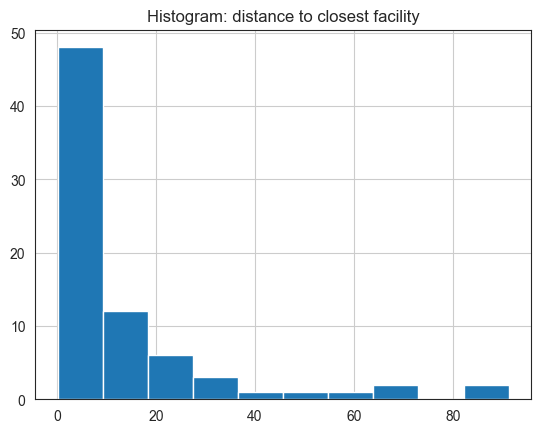

In [175]:
plt.figure()
gdf_utm["min_distance"].hist()
plt.title("Histogram: distance to closest facility")
plt.show()

In [207]:
anc.query("consultation_reason == 2 & province=='Maputo Cidade'").groupby("treatment")["waiting_time"].mean()

treatment
0    142.670973
1     98.019811
Name: waiting_time, dtype: float64

## GRAPHS

<ipython-input-204-e7d7238aa9c0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  followup["urban_labeled"] = followup["urban"]


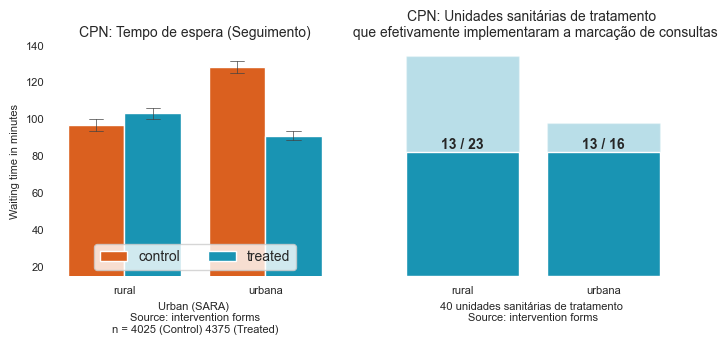

In [204]:
followup = anc.query("consultation_reason == 2")

followup["urban_labeled"] = followup["urban"]
followup = followup.replace({"urban_labeled":{0:"rural", 1:"urbana"}})

order_urban = ["rural", "urbana"]

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
g = sns.barplot(followup, x="urban_labeled",
            y="waiting_time",
            hue="treatment_status",
            palette=palette_anc,
            hue_order=order,errwidth=0.5, capsize=0.1)
plt.title("CPN: Tempo de espera (Seguimento)" ,fontsize=10)

plt.xlabel("Urban (SARA) \n" + SOURCE_WT_FORMS + "\n" + size_followup(anc), size=8)
sns.move_legend(g, "lower center", ncol=2, title="", frameon=True)
plt.ylabel("Waiting time in minutes", fontsize=8)
plt.ylim([15,140])
format_graph()

plt.subplot(1, 2, 2)

complier_df["urban_labeled"] = complier_df["urban"]
complier_df = complier_df.replace({"urban_labeled":{0:"rural", 1:"urbana"}})

order_urban = ["rural", "urbana"]
sns.countplot(complier_df.query("treatment == 1"), x="urban_labeled", 
            color=TREATED, order=order_urban, **dict(alpha=0.3))
ax = sns.countplot(complier_df.query("treatment == 1 & complier == 1"),
                    x="urban_labeled", order=order_urban, color=TREATED)
ax.text(0, 13.3, "13 / 23", ha='center', weight='bold')
ax.text(1, 13.3, "13 / 16", ha='center',weight='bold')

title="CPN: Unidades sanitárias de tratamento \n que efetivamente implementaram a marcação de consultas"
plt.title(title ,fontsize=10)
plt.xlabel("40 unidades sanitárias de tratamento \n" + SOURCE_WT_FORMS, size=8)
sns.despine(left=True, bottom=True)
plt.ylabel("Percentage of patientes", fontsize=8)
format_graph()
plt.yticks([])
plt.ylabel("")

plt.show()

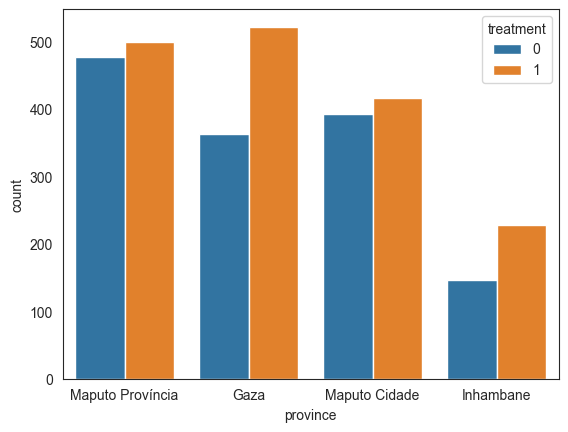

In [190]:
sns.countplot(anc.query("consultation_reason == 1"), x="province", hue="treatment")
plt.show()

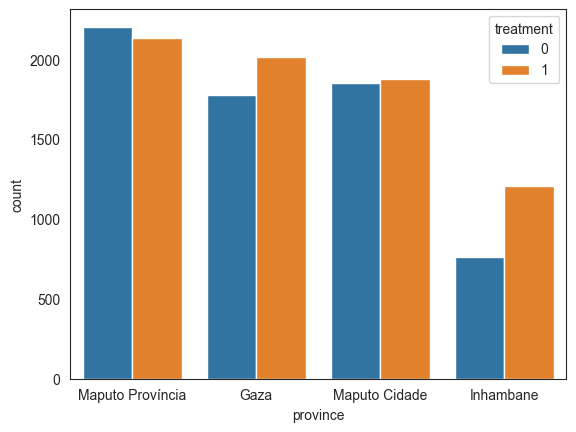

In [208]:
sns.countplot(anc, x="province", hue="treatment")
plt.show()

In [ ]:
anc["maputo"] = 0
q_maputo = anc.eval("facility_name.isin(['Maputo Cidade', 'Maputo Província'])")
anc.loc[q_maputo, "maputo"] = 1

In [248]:
anc["maputo"] = 0
q_maputo = anc.eval("facility_name.isin(['Maputo Cidade', 'Maputo Província'])")
anc.loc[q_maputo, "maputo"] = 1

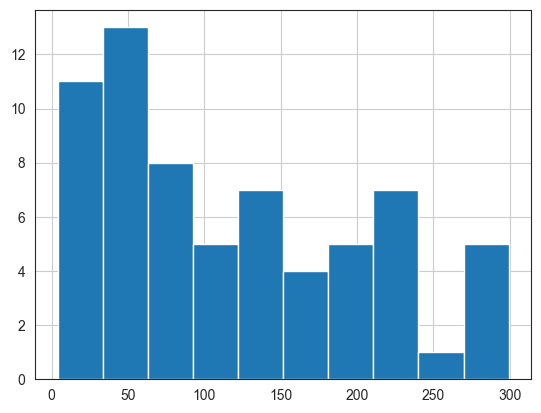

In [259]:
anc.groupby("facility_cod")["pat_nurses"].first().hist()
plt.show()

In [ ]:
    plt.figure()
    complier_eval = complier_df.eval("index_anc_readiness.notna()")
    prepared,labels_prep = column_by_quantile(complier_df.loc[complier_eval], 
                                            "index_anc_readiness", 3,
                                            n_round=2,format_int=False)
    complier_df.loc[complier_eval, "prep"] = prepared

    order_prep=['0.1-0.6', '0.6-0.77', '0.77-1.0']

    sns.countplot(complier_df.query("treatment == 1"), x="prep", 
                color=TREATED,  order=order_prep, **dict(alpha=0.3))
    ax = sns.countplot(complier_df.query("treatment == 1 & complier == 1"),
                        x="prep", order=order_prep, color=TREATED)

    ax.text(0, 7.3, "7 / 8", ha='center', weight='bold')
    ax.text(1, 12.3, "12 / 18", ha='center',weight='bold')
    ax.text(2, 6.3, "6 / 12", ha='center', weight='bold')

    plt.title("ANC: Number of complying facilities by ANC preparedness" ,fontsize=10)
    plt.xlabel("ANC preparedness index - SISMA (40 treated facilities)\n" + SOURCE_WT_FORMS, size=8)
    sns.despine(left=True, bottom=True)
    plt.ylabel("Percentage of patientes", fontsize=8)
    format_graph()
    plt.yticks([])
    plt.ylabel("")
    plt.savefig(f"{img}/compliers_by_preparedness.jpeg", bbox_inches='tight', dpi=300)


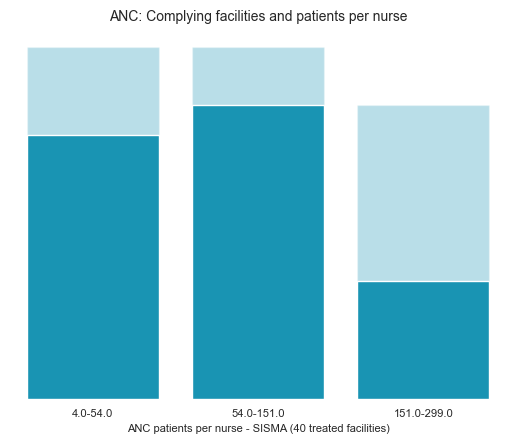

In [268]:
complier_df = complier_df.query("n_nurses != 0 & n_nurses.notna()")
complier_df["pat_nurses"] = complier_df["volume_base_total"] / complier_df["n_nurses"]

plt.figure()
patnurses,labels_patnurses = column_by_quantile(complier_df, 
                                        "pat_nurses", 3,
                                        n_round=0,format_int=False)

order_nurses=labels_patnurses#['4.0-53.0', '53.0-153.0', '153.0-299.0']
complier_df["pat_nurses_groups"] = patnurses

sns.countplot(complier_df.query("treatment == 1"), x="pat_nurses_groups", 
            color=TREATED,  order=order_nurses, **dict(alpha=0.3))
ax = sns.countplot(complier_df.query("treatment == 1 & complier == 1"),
                    x="pat_nurses_groups", order=order_nurses, color=TREATED)

plt.title("ANC: Complying facilities and patients per nurse" ,fontsize=10)
plt.xlabel("ANC patients per nurse - SISMA (40 treated facilities)", size=8)
sns.despine(left=True, bottom=True)
plt.ylabel("Percentage of patientes", fontsize=8)
format_graph()
plt.yticks([])
plt.ylabel("")

plt.show()

In [277]:
np.quantile(anc.query("consultation_reason == 1")["waiting_time"], 0.95)

281.0

In [273]:
np.quantile(anc.query("consultation_reason == 2")["waiting_time"], 
            0.8)

165.0

In [276]:
anc.query("consultation_reason == 2 & urban == 1").groupby("treatment")["waiting_time"].mean()

treatment
0    128.363439
1     91.086622
Name: waiting_time, dtype: float64

In [ ]:
followup = anc.query("consultation_reason == 2")

followup["urban_labeled"] = followup["urban"]
followup = followup.replace({"urban_labeled":{0:"rural", 1:"urbana"}})

order_urban = ["rural", "urbana"]

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
g = sns.barplot(followup, x="urban_labeled",
            y="waiting_time",
            hue="treatment_status",
            palette=palette_anc,
            hue_order=order,errwidth=0.5, capsize=0.1)
plt.title("CPN: Tempo de espera (Seguimento)" ,fontsize=10)

plt.xlabel("Urban (SARA) \n" + SOURCE_WT_FORMS + "\n" + size_followup(anc), size=8)
sns.move_legend(g, "lower center", ncol=2, title="", frameon=True)
plt.ylabel("Waiting time in minutes", fontsize=8)
plt.ylim([15,140])
format_graph()

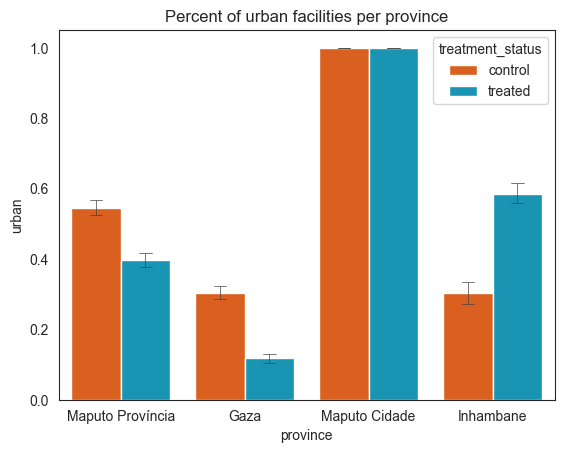

In [287]:

sns.barplot(anc, x="province",
            y="urban",
            hue="treatment_status",
            palette=palette_anc,
            hue_order=order,errwidth=0.5, capsize=0.1)
plt.title("Percent of urban facilities per province")
plt.show()

Where it worked and why?
where it didn't and why?

In [302]:
(anc.query("consultation_reason == 1")
    .groupby(["province","urban","treatment"])
 ["waiting_time"].mean().astype(int))

province          urban  treatment
Gaza              0.0    0             84
                         1            100
                  1.0    0             62
                         1             75
Inhambane         0.0    0             72
                         1            130
                  1.0    0             97
                         1            154
Maputo Cidade     1.0    0            174
                         1            111
Maputo Província  0.0    0            147
                         1            131
                  1.0    0            160
                         1             98
Name: waiting_time, dtype: int64

In [303]:
facility_characteristics.groupby("province").size()

province
Gaza                31
Inhambane           10
Maputo Cidade       14
Maputo Província    25
dtype: int64

In [ ]:
anc.query("consultation_reason == 2").groupby("province")

In [296]:
(anc.query("consultation_reason == 2")
    .groupby(["province","urban","treatment"])
 ["waiting_time"].mean())

province          urban  treatment
Gaza              0.0    0             78.416537
                         1             83.319257
                  1.0    0             57.219941
                         1             56.851429
Inhambane         0.0    0             96.685792
                         1            116.537859
                  1.0    0            112.197531
                         1            110.601375
Maputo Cidade     1.0    0            142.670973
                         1             98.019811
Maputo Província  0.0    0            113.446154
                         1            120.224680
                  1.0    0            144.431925
                         1             78.338768
Name: waiting_time, dtype: float64

In [ ]:
(anc.query("consultation_reason == 2 & province == 'Gaza'")
    .groupby(["treatment","urban"])
 ["waiting_time"].mean())

In [5]:
ROOT

'/Users/rafaelfrade/arquivos/desenv/lse/anc_hiv_scheduling/data'

In [21]:

#cols_pb = provider_base.columns
#provider_base = provider_base.merge(facility_characteristics,
#                                    left_on="codigo",
#                                    right_on="facility_cod")

In [34]:
provider_base.groupby("province").size()

province
Maputo City        38
Maputo Province    67
Gaza               81
Inhambane          25
dtype: int64

In [62]:
[c for c in anc if "pat" in c]

['n_rooms_chronic_patients',
 'where_CD4_patients',
 'pat_nurses',
 'low_pat_nurses']

In [ ]:
facility_characteristics.groupby("province")["complier"].mean()

In [46]:
(facility_characteristics.query("treatment == 1")
    .groupby(["province", "urban"])["complier"].mean())

province          urban
Gaza              0.0      0.500000
                  1.0      1.000000
Inhambane         0.0      0.666667
                  1.0      0.500000
Maputo Cidade     1.0      0.750000
Maputo Província  0.0      0.666667
                  1.0      1.000000
Name: complier, dtype: float64

In [91]:
(facility_characteristics
     .query("province == 'Inhambane'")
 .groupby("urban")
 [[
  "score_basic_amenities",
  "score_basic_equipment",
  "index_general_service",
  "index_anc_readiness",
  "volume_base_total"]]
 .mean()
)

,score_basic_amenities,score_basic_equipment,index_general_service,index_anc_readiness,volume_base_total
urban,,,,,
0.0,0.857143,0.90476,0.780159,0.7,404.111115
1.0,0.833333,0.88889,0.717040,0.6,449.703705


In [122]:
(facility_characteristics
    .groupby(["province", "urban"])
            ["facility_cod"].size())

province          urban
Gaza              0.0      26
                  1.0       5
Inhambane         0.0       7
                  1.0       3
Maputo Cidade     1.0      14
Maputo Província  0.0      17
                  1.0       8
Name: facility_cod, dtype: int64

In [96]:
(anc.query("consultation_reason == 2")
    .groupby(["province", "urban", "treatment"])
            ["waiting_time"].mean())

province          urban  treatment
Gaza              0.0    0             78.416537
                         1             83.319257
                  1.0    0             57.219941
                         1             56.851429
Inhambane         0.0    0             96.685792
                         1            116.537859
                  1.0    0            112.197531
                         1            110.601375
Maputo Cidade     1.0    0            142.670973
                         1             98.019811
Maputo Província  0.0    0            113.446154
                         1            120.224680
                  1.0    0            144.431925
                         1             78.338768
Name: waiting_time, dtype: float64

,n_nurses,facility_cod
0,4.0,1
1,2.0,2
2,15.0,3
3,4.0,4
4,3.0,5
...,...,...
75,11.0,79
76,10.0,80
77,NaN,81
78,NaN,83


In [129]:
def mode(series):
    mode_series = series.mode()
    if type(mode_series) is int:
        return mode_series
    
    return mode_series.mean()

In [348]:
prov_anc_endline = (page2_providers
                        .groupby("facility_cod")
                        ["n_providers_page_2"].agg(mode)
                    .reset_index())
prov_anc_endline["n_providers_page_2"] = prov_anc_endline["n_providers_page_2"].astype(int)
prov_anc_baseline = facility_characteristics[["n_rooms_anc", "facility_cod"]]

providers = prov_anc_endline.merge(prov_anc_baseline, on="facility_cod")

In [353]:
[print(row) for i, row in providers.iterrows()]

facility_cod          1.0
n_providers_page_2    3.0
n_rooms_anc           2.0
Name: 0, dtype: float64
facility_cod          2.0
n_providers_page_2    1.0
n_rooms_anc           1.0
Name: 1, dtype: float64
facility_cod          3.0
n_providers_page_2    2.0
n_rooms_anc           1.0
Name: 2, dtype: float64
facility_cod          4.0
n_providers_page_2    1.0
n_rooms_anc           1.0
Name: 3, dtype: float64
facility_cod          5.0
n_providers_page_2    3.0
n_rooms_anc           2.0
Name: 4, dtype: float64
facility_cod          6.0
n_providers_page_2    1.0
n_rooms_anc           2.0
Name: 5, dtype: float64
facility_cod          7.0
n_providers_page_2    1.0
n_rooms_anc           1.0
Name: 6, dtype: float64
facility_cod          8.0
n_providers_page_2    1.0
n_rooms_anc           1.0
Name: 7, dtype: float64
facility_cod          9.0
n_providers_page_2    1.0
n_rooms_anc           NaN
Name: 8, dtype: float64
facility_cod          10.0
n_providers_page_2     2.0
n_rooms_anc            2.0
N

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

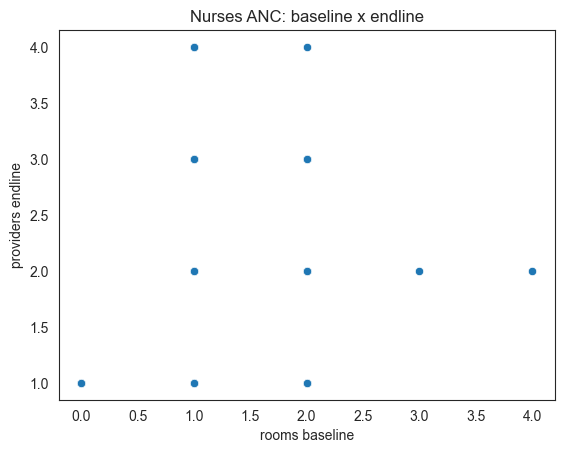

In [350]:
sns.scatterplot(providers, x="n_rooms_anc", y="n_providers_page_2", )
plt.title("Nurses ANC: baseline x endline")
plt.xlabel("rooms baseline")
plt.ylabel("providers endline")
plt.show()

In [347]:
[c for c in anc if "rooms" in c]

['n_rooms_mch', 'n_rooms_anc', 'n_rooms_chronic_patients']

In [345]:
sns.scatterplot(providers, x="n_rooms_anc", y="n_providers_page_2")
plt.title("Nurses ANC: baseline x endline")
plt.xlabel("nurses baseline")
plt.ylabel("providers endline")
plt.show()

ValueError: Could not interpret value `n_rooms_anc` for parameter `x`

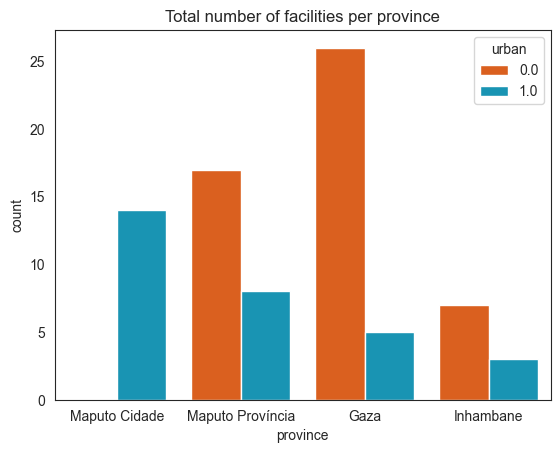

In [268]:
img = "/Users/rafaelfrade/arquivos/desenv/lse/anc_hiv_scheduling/graphs"

sns.countplot(facility_characteristics, 
                x="province", hue="urban", palette=palette_anc)
plt.title("Total number of facilities per province")
plt.savefig(f"{img}/urban_fac_by_province.jpeg", bbox_inches='tight', dpi=300)
plt.show()

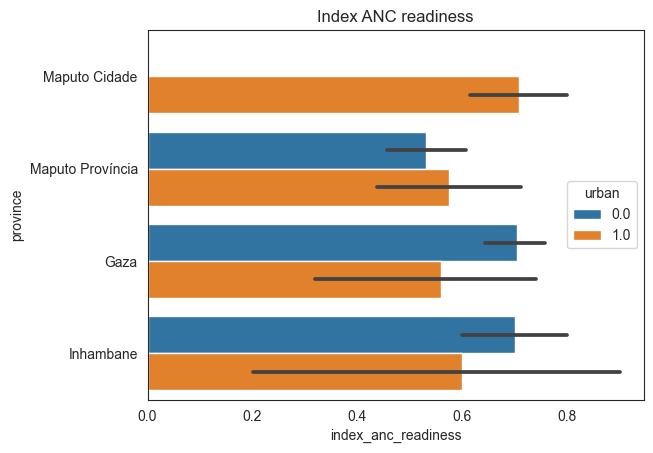

In [146]:
sns.barplot(facility_characteristics,
               x="index_anc_readiness", y="province", hue="urban")
plt.title("Index ANC readiness")
plt.show()

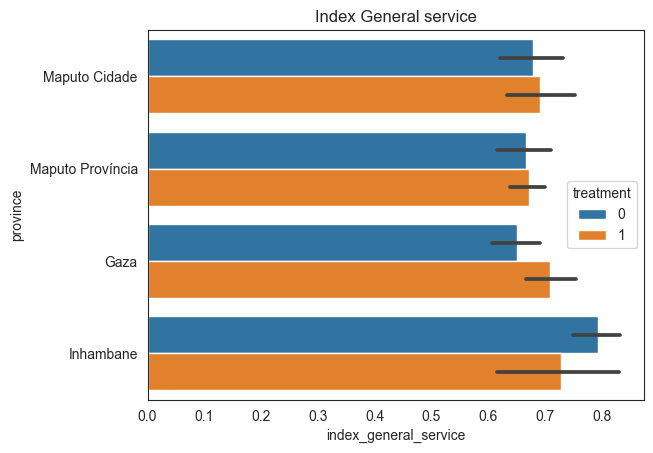

In [177]:
sns.barplot(facility_characteristics,
               x="index_general_service", y="province", hue="treatment")
plt.title("Index General service")
plt.show()

In [172]:
facility_characteristics["distance_district_minutes"] = (facility_characteristics["distance_district_minutes"]
                            .replace({"":np.nan}))
facility_characteristics["distance_district_minutes"] = facility_characteristics["distance_district_minutes"].astype(float)

/opt/homebrew/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


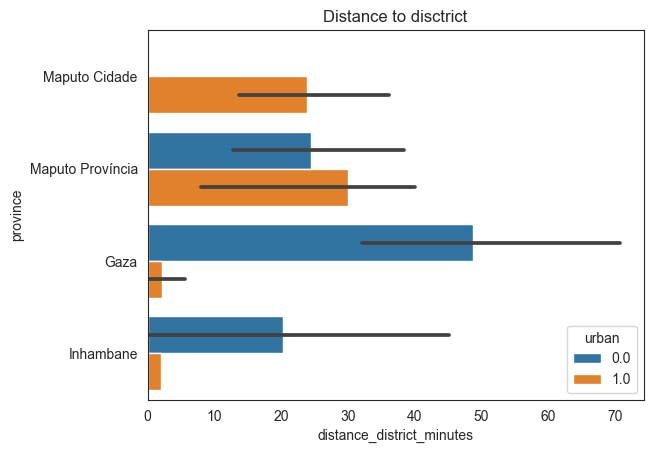

In [174]:
sns.barplot(facility_characteristics,
               x="distance_district_minutes", y="province", hue="urban")
plt.title("Distance to disctrict")
plt.show()


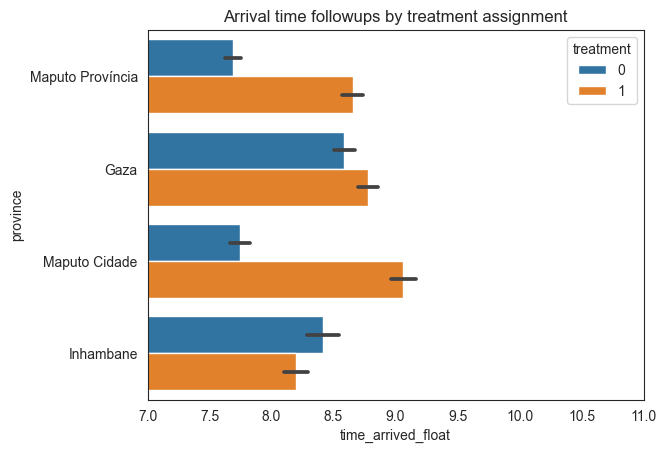

In [194]:
sns.barplot(anc.query("consultation_reason == 2"), x="time_arrived_float",
            y="province", hue="treatment")
plt.xlim([7,11])
plt.title("Arrival time followups by treatment assignment")
plt.show()

/opt/homebrew/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


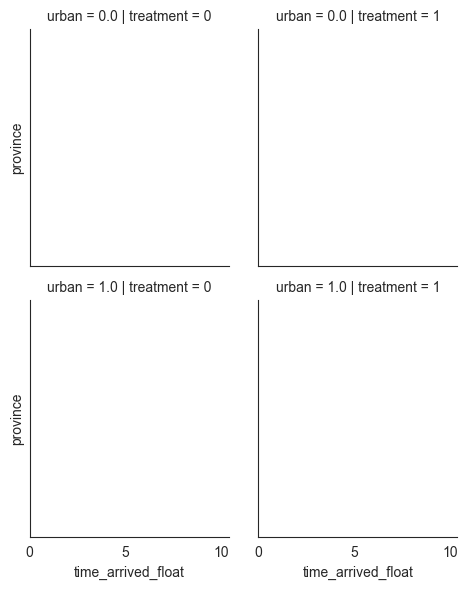

In [284]:
g = sns.FacetGrid(anc, col="treatment",  row="urban")
g.map(sns.barplot, "time_arrived_float", "province")
g.set(ylim=(7,11))
plt.show()

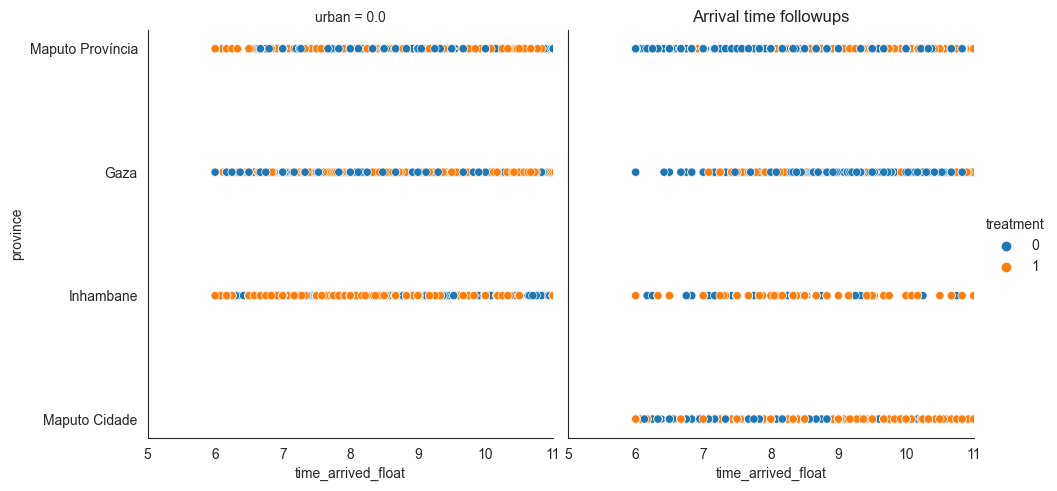

In [270]:
sns.relplot(anc.query("consultation_reason == 2"), x="time_arrived_float",
            y="province", hue="treatment", col="urban")
plt.xlim([5,11])
plt.title("Arrival time followups")


g = sns.FacetGrid(anc, col="treatment",  row="urban")
g.map(sns.barplot, "time_arrived_float", "province")

plt.show()

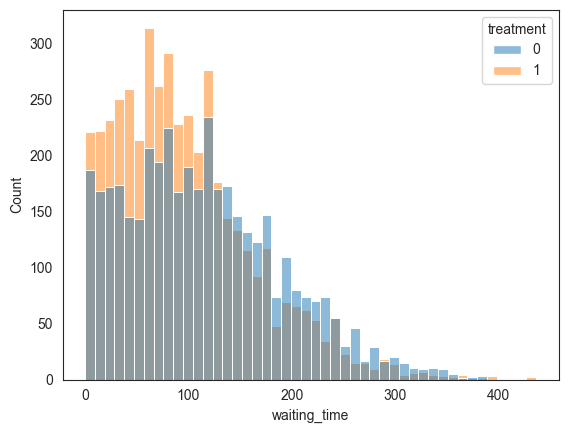

In [208]:


sns.histplot(anc.query("consultation_reason == 2"),
                x="waiting_time", hue="treatment")
plt.show()

In [33]:
text = "years_worked months_worked pat_pb_effective pat_insensitive feel_drained feel_fatigued feel_callous feel_positive feel_strain pat_notcare feel_satisfied improve_oth_spec improve_support improve_training improve_drug improve_supply improve_eqpt improve_wkload improve_wkhrs improve_incentives improve_safety improve_facility improve_water improve_indep improve_emotion improve_mentor improve_oth improve123_oth_spec improve1_support improve1_training improve1_drug improve1_supply improve1_eqpt improve1_wkload improve1_wkhrs improve1_incentives improve1_safety improve1_facility improve1_water improve1_indep improve1_emotion improve1_mentor improve1_oth improve2_support improve2_training improve2_drug improve2_supply improve2_eqpt improve2_wkload improve2_wkhrs improve2_incentives improve2_safety improve2_facility improve2_water improve2_indep improve2_emotion improve2_mentor improve2_oth improve3_support improve3_training improve3_drug improve3_supply improve3_eqpt improve3_wkload improve3_wkhrs improve3_incentives improve3_safety improve3_facility improve3_water improve3_indep improve3_emotion improve3_mentor improve3_oth improve4_support improve4_training improve4_drug improve4_supply improve4_eqpt improve4_wkload improve4_wkhrs improve4_incentives improve4_safety improve4_facility improve4_water improve4_indep improve4_emotion improve4_mentor improve4_oth pat_ease pat_cmp_impact pat_HIVtrust pat_jdg_impact satisfy_wk satisfy_tm satisfy_sprv challenge_oth_spec challenge_1 challenge_2 challenge_3 challenge_4 challenge_5 challenge_6 challenge_7 challenge_oth hc_supvr id_supvr last_disc disc_diff disc_impr your_mstk rjct_diff ask_diff undrmn unq_val drt_comm drt_list drt_safe drt_trust drt_adapt drt_resp drt_invest drt_commit wkhrs_day pay_pp sec_job GAAC aware_GAAC part_GAAC impl_GAAC ready_GAAC compl_GAAC exp_GAAC cfam aware_cfam part_cfam impl_cfam ready_cfam compl_cfam exp_cfam d4 aware_d4 part_d4 impl_d4 ready_d4 compl_d4 exp_d4 d2 aware_d2 part_d2 impl_d2 ready_d2 compl_d2 exp_d2 othHIV_name othHIV_yr othHIV intrv_will intrv_priv other_notes"
for col in text.split(" "):
    print(col)
    print(provider_base.groupby("province")[col].value_counts(normalize=True))
    print("\n")

years_worked
province     years_worked
Maputo City  0.0             0.263158
             1.0             0.184211
             5.0             0.157895
             4.0             0.105263
             2.0             0.078947
                               ...   
Inhambane    22.0            0.000000
             23.0            0.000000
             25.0            0.000000
             2.0             0.000000
             28.0            0.000000
Name: proportion, Length: 96, dtype: float64


months_worked
province         months_worked
Maputo City      0.0              0.394737
                 7.0              0.131579
                 9.0              0.131579
                 10.0             0.105263
                 5.0              0.052632
                 3.0              0.052632
                 1.0              0.026316
                 8.0              0.026316
                 6.0              0.026316
                 4.0              0.026316
                 2.0 

Name: proportion, dtype: float64


improve4_wkhrs
province         improve4_wkhrs
Maputo City      0.0               1.000000
                 1.0               0.000000
Maputo Province  0.0               0.985075
                 1.0               0.014925
Gaza             0.0               1.000000
                 1.0               0.000000
Inhambane        0.0               1.000000
                 1.0               0.000000
Name: proportion, dtype: float64


improve4_incentives
province         improve4_incentives
Maputo City      0.0                    1.000000
                 1.0                    0.000000
Maputo Province  0.0                    0.985075
                 1.0                    0.014925
Gaza             0.0                    1.000000
                 1.0                    0.000000
Inhambane        0.0                    1.000000
                 1.0                    0.000000
Name: proportion, dtype: float64


improve4_safety
province         improve4_safet

No difference in the working hours. Some difference in the salary between the provinces, but not relevant (Inhambane > Maputo city).



In [ ]:
provider_base.groupby("province")[col]

In [215]:
[x for x in facility_characteristics if "13" in x]

['Q013_B']

In [243]:
import geopandas
distance_df = (facility_characteristics[["facility_cod", "Q013_B", "Q014_B"]])
distance_df = distance_df[pd.to_numeric(distance_df['Q013_B'], errors='coerce').notnull()]

distance_df["lat"] = distance_df["Q013_B"].astype(float)
distance_df["lon"] = distance_df["Q014_B"].astype(float)
gdf = geopandas.GeoDataFrame(
    distance_df, geometry=geopandas.points_from_xy(distance_df.Q014_B, distance_df.Q013_B),
    crs="EPSG:4326"
)


In [257]:
from shapely.geometry import Point
from geopy.distance import geodesic

gdf.to_crs(epsg=3310,inplace=True)
point = Point(32.588711, -25.953724)
gdf.distance(point)/1000

distances_to_maputo = {"facility_cod":[], 
                       "distance_to_maputo":[]}
for i, row in distance_df.iterrows():
    dist = geodesic((row["lon"],row["lat"]),(32.588711,-25.953724)).kilometers
    
    distances_to_maputo["facility_cod"].append( row["facility_cod"] )
    distances_to_maputo["distance_to_maputo"].append( round(dist) )
    
dist_df = pd.DataFrame(distances_to_maputo)
facility_characteristics = facility_characteristics.merge(dist_df, on="facility_cod", how="left")

In [260]:
facility_characteristics.groupby("province")["distance_to_maputo"].mean()

province
Gaza                144.548387
Inhambane           356.900000
Maputo Cidade         6.071429
Maputo Província     36.904762
Name: distance_to_maputo, dtype: float64

In [261]:
facility_characteristics.to_csv(f"{AUX}/facility_characteristics.csv", mode="w")

In [ ]:
drt_comm drt_list drt_safe drt_trust drt_adapt drt_resp drt_invest drt_commit

In [286]:
provider_base = pd.read_stata(f"{ROOT}/baseline_survey/provider.dta")

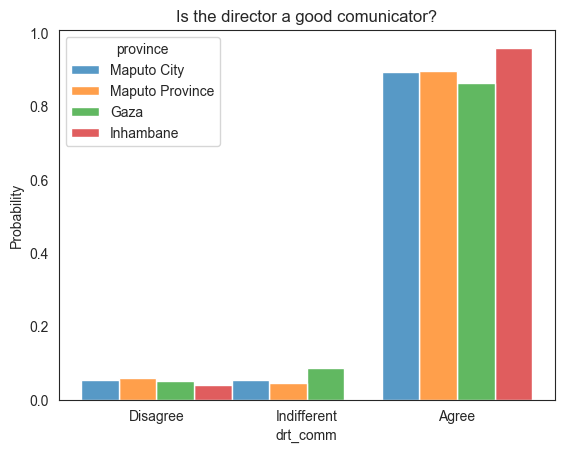

In [328]:
#{“layer”, “dodge”, “stack”, “fill”}

sns.histplot(provider_base, x="drt_comm", hue="province", 
             multiple="dodge", common_norm=False, stat="probability")
plt.title("Is the director a good comunicator?")
plt.show()

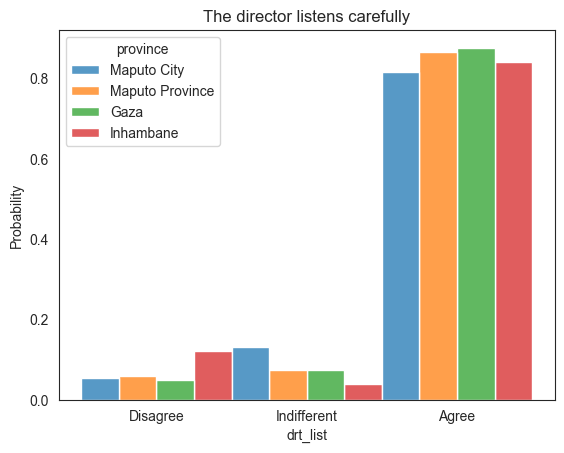

In [301]:
sns.histplot(provider_base, x="drt_list", hue="province", 
             multiple="dodge", common_norm=False, stat="probability")
plt.title("The director listens carefully")
plt.show()

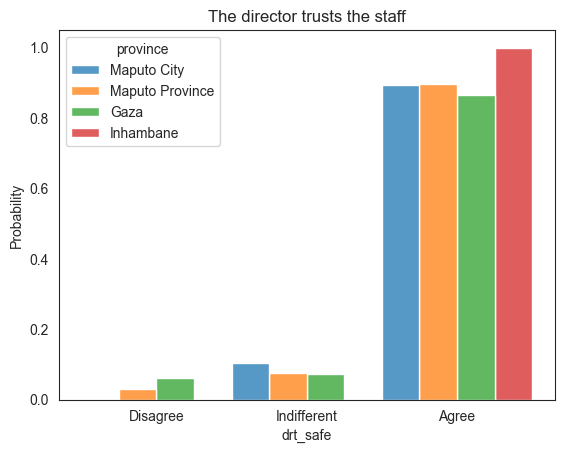

In [302]:
sns.histplot(provider_base, x="drt_safe", hue="province", 
             multiple="dodge", common_norm=False, stat="probability")
plt.title("The director trusts the staff")
plt.show()

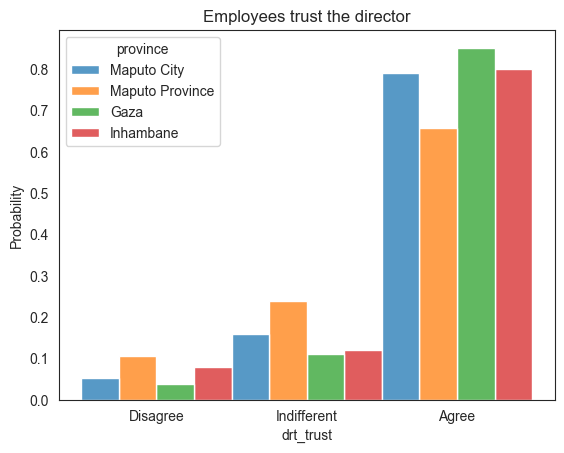

In [303]:
sns.histplot(provider_base, x="drt_trust", hue="province", 
             multiple="dodge", common_norm=False, stat="probability")
plt.title("Employees trust the director")
plt.show()

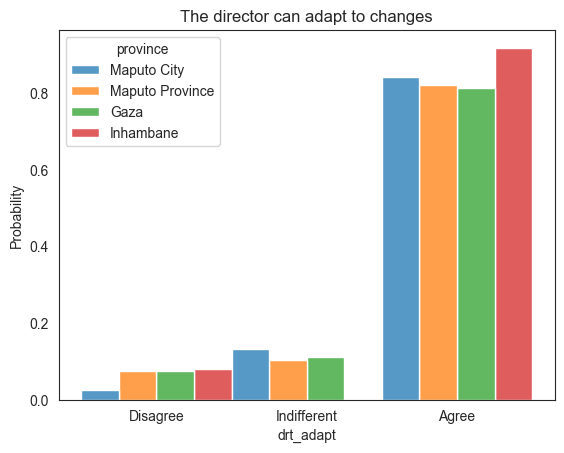

In [304]:
sns.histplot(provider_base, x="drt_adapt", hue="province", 
             multiple="dodge", common_norm=False, stat="probability")
plt.title("The director can adapt to changes")
plt.show()

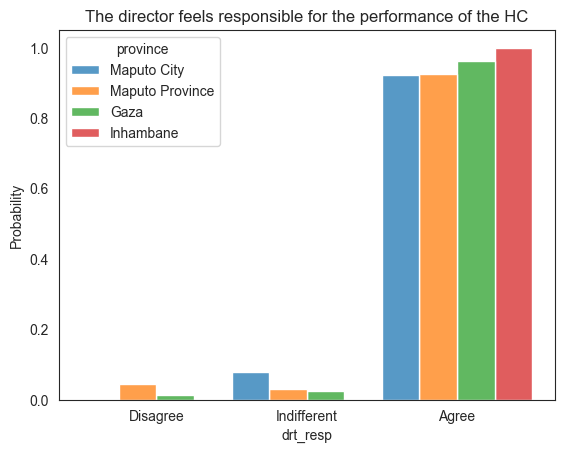

In [305]:
sns.histplot(provider_base, x="drt_resp", hue="province", 
             multiple="dodge", common_norm=False, stat="probability")
plt.title("The director feels responsible for the performance of the HC")
plt.show()

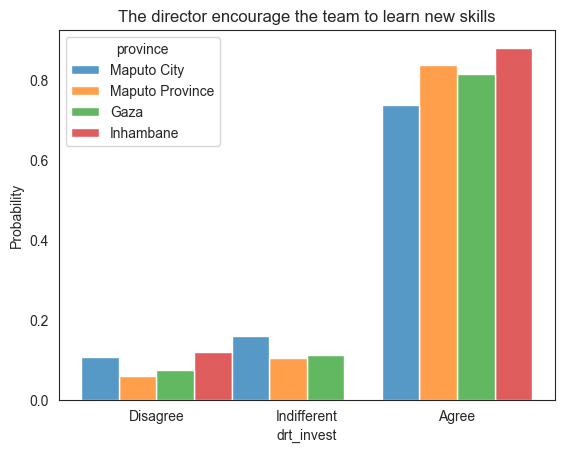

In [306]:

sns.histplot(provider_base, x="drt_invest", hue="province", 
             multiple="dodge", common_norm=False, stat="probability")
plt.title("The director encourage the team to learn new skills")
plt.show()

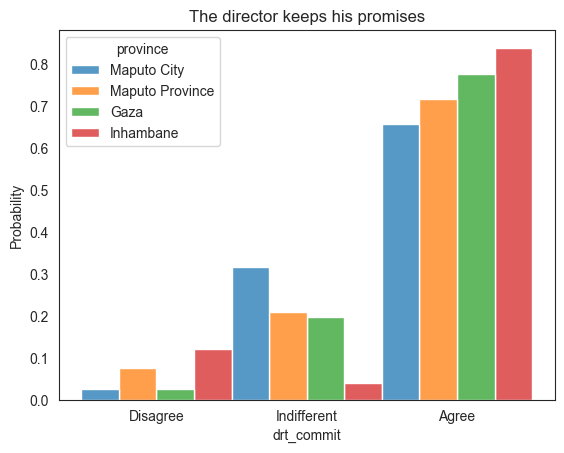

In [307]:

sns.histplot(provider_base, x="drt_commit", hue="province", 
             multiple="dodge", common_norm=False, stat="probability")
plt.title("The director keeps his promises")
plt.show()

In [315]:
chal = {1:"chalange: lack of equipment",
        2:"chalange: volume of patients",
        3:"chalange: lack of medication",
        4:"chalange: lack of supervision",
        5:"chalange: relationship with colleagues",
        6:"chalange: relationship with patients"}
chal.items()

dict_items([(1, 'chalange: lack of equipment'), (2, 'chalange: volume of patients'), (3, 'chalange: lack of medication'), (4, 'chalange: lack of supervision'), (5, 'chalange: relationship with colleagues'), (6, 'chalange: relationship with patients')])

In [319]:
for k, v in chal.items():
    print(f"challange_{k}", v)

challange_1 chalange: lack of equipment
challange_2 chalange: volume of patients
challange_3 chalange: lack of medication
challange_4 chalange: lack of supervision
challange_5 chalange: relationship with colleagues
challange_6 chalange: relationship with patients


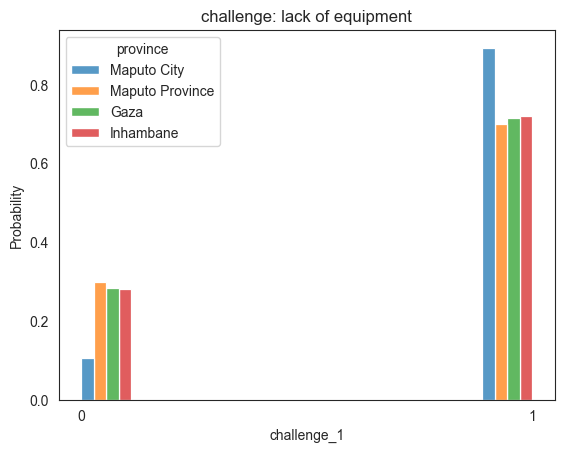

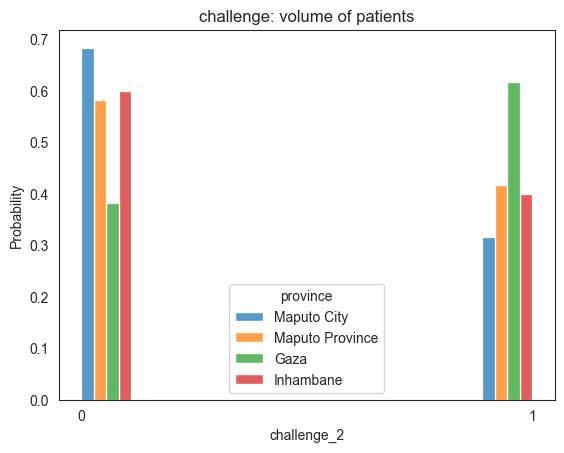

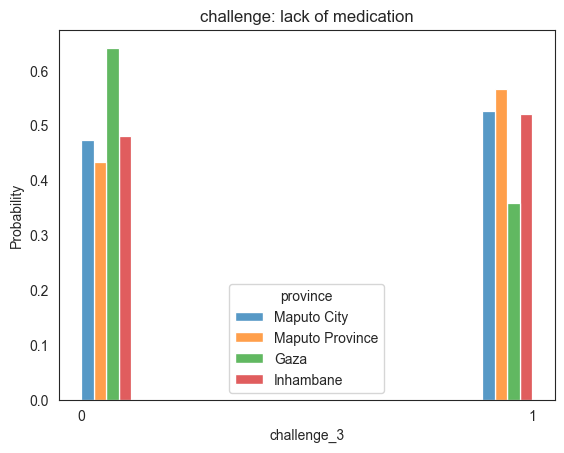

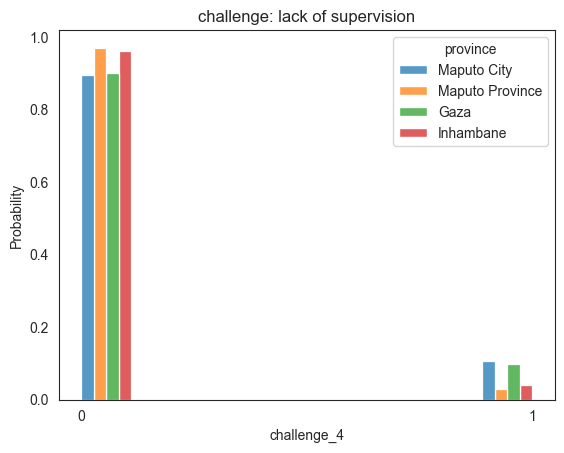

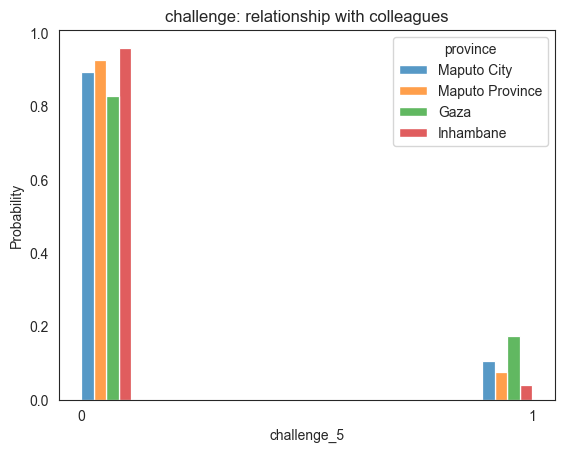

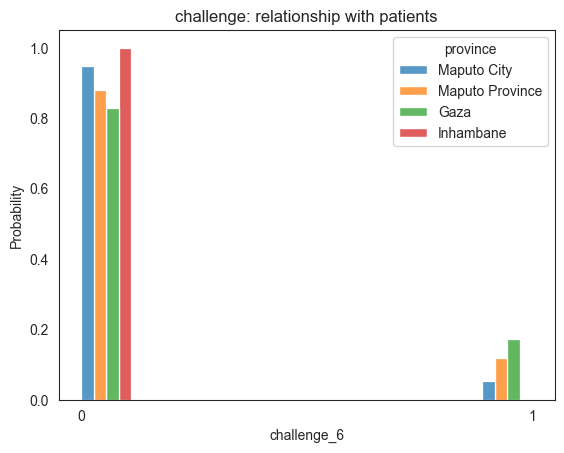

In [327]:
chal = {1:"challenge: lack of equipment",
        2:"challenge: volume of patients",
        3:"challenge: lack of medication",
        4:"challenge: lack of supervision",
        5:"challenge: relationship with colleagues",
        6:"challenge: relationship with patients"}

for k, v in chal.items():

    sns.histplot(provider_base, x=f"challenge_{k}", hue="province", 
                 multiple="dodge", common_norm=False, stat="probability")
    plt.title(v)
    plt.xticks([0,1])
    plt.show()

In [ ]:
DEFINITION

SHARE OF PATIENTS SCHEDULED 10 OR LATER

In [357]:
[x for x in anc if "sche" in x]

['time_scheduled_cleaned',
 'scheduled_mean_fac',
 'time_scheduled_hours',
 'scheduled_std']

## Scheduled patients per hour

In [955]:
anc_path = f"{CLEANED_DATA_PATH}/anc_cpn_endline_v20230704.csv"
anc = pd.read_csv(anc_path)
anc.query("complier == 1")["facility_cod"].nunique()

<ipython-input-955-1758afe76121>:2: DtypeWarning: Columns (40,41,127) have mixed types. Specify dtype option on import or set low_memory=False.
  anc = pd.read_csv(anc_path)


42

In [952]:
anc_path = f"{CLEANED_DATA_PATH}/anc_cpn_endline_v20230704.csv"
anc = pd.read_csv(anc_path)
anc = anc.sort_values(["facility_cod", "time_entered"])

first_consultations = (anc
    .groupby(["facility_cod", "treatment"])["time_entered"]
    .first().reset_index())

anc["scheduled"] = 0
anc.loc[anc["time_scheduled_hours"].notna(), "scheduled"] = 1

anc["followup"] = 0
anc.loc[anc.eval("consultation_reason == 2"), "followup"] = 1

anc["pct_scheduled"] = 0
pct_scheduled = (anc.query("consultation_reason == 2")
    .groupby(["facility_cod"])["scheduled"]
    .mean().reset_index().rename(columns={"scheduled":"pct_scheduled"}))

anc["sched_9"] = 0
q_after9 = anc.eval("time_scheduled_hours >= 900")
anc.loc[q_after9, "sched_9"] = 1
sched_after_9 = (anc.query("consultation_reason == 2")
    .groupby(["facility_cod"])["sched_9"]
    .mean().reset_index())

anc["sched_10"] = 0
q_after10 = anc.eval("time_scheduled_hours >= 1000")
anc.loc[q_after10, "sched_10"] = 1
sched_after_10 = (anc.query("consultation_reason == 2")
    .groupby(["facility_cod"])["sched_10"]
    .mean().reset_index())

time_scheduled_fac = (anc.query("consultation_reason == 2")
    .groupby(["facility_cod"])["time_scheduled_hours"]
    .mean().reset_index())

first_consultations = (first_consultations
                    .merge(pct_scheduled, on=["facility_cod"])
                    .merge(n_followups_day, on=["facility_cod"])
                    .merge(sched_after_9, on=["facility_cod"])
                    .merge(sched_after_10, on=["facility_cod"])
                    .merge(time_scheduled_fac, on=["facility_cod"]) )

<ipython-input-952-f0aa56e79d68>:2: DtypeWarning: Columns (40,41,127) have mixed types. Specify dtype option on import or set low_memory=False.
  anc = pd.read_csv(anc_path)


In [ ]:
54, 66, 18

In [949]:
first_consultations.query("pct_scheduled > 0.2 & sched_9 < 0.2")

,facility_cod,treatment,time_entered,pct_scheduled,followup,sched_9,sched_10,time_scheduled_hours
3,4,1,740,1.000000,65,0.000000,0.000000,830.000000
9,10,1,750,0.329670,182,0.159341,0.131868,1121.583333
25,28,1,741,0.340426,47,0.106383,0.000000,829.375000
56,60,1,730,0.923077,78,0.000000,0.000000,722.222222
66,70,1,715,0.953917,217,0.188940,0.059908,818.888889
74,78,1,755,0.854545,55,0.054545,0.036364,810.638298


In [951]:
facility_characteristics.query("treatment == 0 & complier == 1")

,v1,facility_cod,hospital,complier,full_complier,volume_base_total,volume_base_1st,volume_base_followup,province,district,...,has_mch_art_appoint,daily_lectures_art,date_completion,distance_district_minutes,cd4_mesma_us,hemograma_mesma_us,has_lab_num,has_reception_num,maputo,distance_to_maputo
4,4,5,0.0,1.0,0.0,689.333313,237.000000,452.333344,Maputo Cidade,Kamavota,...,não,sim,,30.0,0.0,0.0,1.0,1.0,1,2.0
35,35,39,0.0,1.0,0.0,335.000000,96.666664,238.333328,Maputo Província,Moamba,...,sim,sim,,3.0,0.0,0.0,1.0,1.0,1,NaN


In [950]:
first_consultations.query("sched_9 > 0.2 & sched_10 < 0.2")

,facility_cod,treatment,time_entered,pct_scheduled,followup,sched_9,sched_10,time_scheduled_hours
16,18,1,803,0.811966,117,0.760684,0.179487,931.063158
50,54,1,730,0.434109,129,0.240310,0.147287,1057.892857
62,66,1,735,0.432990,97,0.278351,0.185567,950.000000


In [938]:
anc["time_scheduled_hours"].value_counts()

time_scheduled_hours
1000.0     960
800.0      397
730.0      330
1030.0     295
830.0      186
900.0      185
700.0      158
1100.0     149
1200.0      70
930.0       69
1130.0      66
1230.0      29
1300.0      25
1120.0      17
1020.0      16
1040.0      15
1140.0      12
1150.0      12
950.0       11
1050.0      11
920.0       11
850.0       11
810.0       10
940.0       10
1010.0       9
1110.0       9
1115.0       7
840.0        7
815.0        7
1220.0       7
1210.0       6
915.0        6
1250.0       6
1240.0       6
740.0        5
820.0        5
750.0        5
1320.0       5
1155.0       4
1045.0       4
1145.0       4
1400.0       4
1025.0       4
945.0        3
1205.0       3
1135.0       3
855.0        3
825.0        2
1042.0       2
911.0        2
932.0        2
1235.0       2
1015.0       2
935.0        2
1055.0       2
936.0        2
1125.0       2
1156.0       2
745.0        2
711.0        2
1121.0       2
630.0        2
1611.0       2
947.0        2
1012.0       2
1154

In [906]:
n_scheduled_day = (anc.query("consultation_reason == 2")
    .groupby(["facility_cod"])["scheduled"]
    .sum().reset_index())


n_followups_day = (anc.query("consultation_reason == 2")
    .groupby(["facility_cod"])["followup"]
    .sum().reset_index())




first_last_cons = (first_consultations
                    .merge(last_consultations, on=["facility_cod"])
                    .merge(n_scheduled_day, on=["facility_cod"]))




last_consultations = (anc.query("consultation_reason == 2")
    .groupby(["facility_cod", "day"])["time_entered"]
    .last().reset_index())





time_scheduled_fac = (anc.query("consultation_reason == 2")
    .groupby(["facility_cod"])["time_entered"]
    .mean().reset_index())


from datetime import datetime
def time_diff(final_time, initial_time):
    try:
        final = str(final_time)
        size_f = len(final)
        str_f = final[0:(size_f-2)] + ":" + final[(size_f-2):size_f]

        inital = str(initial_time)
        size_i = len(inital)
        str_i = inital[0:(size_i-2)] + ":" + inital[(size_i-2):size_i]

        FMT = '%H:%M'
        return ((datetime.strptime(str_f, FMT) - datetime.strptime(str_i, FMT))
                    .total_seconds()/60)
    except:
        return -1

def time_diff_df(df):
    print(df)
    return time_diff(df["time_entered_y"], df["time_entered_x"])

first_entered = first_last_cons['time_entered_x'].to_list()
last_entered = first_last_cons['time_entered_y'].to_list()
time_span = []

i = 0
for (first, last) in  zip(first_entered, last_entered):
    time_span.append(time_diff(last, first))

first_last_cons["hours_followup"] = time_span
first_last_cons["hours_followup"] = first_last_cons["hours_followup"].div(60)

first_last_cons = first_last_cons.query("hours_followup.notna() & hours_followup > 0") 
first_last_cons["scheduled_per_hour"] = (first_last_cons["scheduled"]
                                            .div(first_last_cons["hours_followup"]))
    
first_last_cons["followup_per_hour"] = (first_last_cons["followup"]
                                            .div(first_last_cons["hours_followup"]))

#first_last_cons = first_last_cons.groupby("facility_cod").mean()
first_last_cons = first_last_cons.reset_index()
first_last_cons = first_last_cons.merge(facility_characteristics, on="facility_cod")



anc = anc.merge(facility_characteristics, left_on=["facility_cod", "treatment"], 
                       right_on=["facility_cod", "treatment"])

first_last_cons = first_last_cons[["facility_cod", "pct_scheduled", "sched_9", "sched_10"]]

first_appoint = first_appoint.sort_values(["facility_cod", "time_entered"])

earlist_time = (first_appoint.groupby("facility_cod")
    ["time_entered_float"].first().round(2)
    .apply(time_float_to_time)
    .reset_index()).rename(columns={"time_entered_float":"earliest_time"})

mean_opening_time = (first_appoint.groupby("facility_cod")
    ["time_entered_float"].mean().round(2)
    .apply(time_float_to_time)
    .reset_index()).rename(columns={"time_entered_float":"mean_opening_time"})

earlist_time = (earlist_time.merge(mean_opening_time, on="facility_cod")
                            .merge(first_last_cons, on="facility_cod"))

<ipython-input-906-0edaffcf9b98>:2: DtypeWarning: Columns (40,41,127) have mixed types. Specify dtype option on import or set low_memory=False.
  anc = pd.read_csv(anc_path)


KeyError: 'scheduled'

In [904]:
first_last_cons

,facility_cod,day_x,time_entered_x,day_y,time_entered_y,scheduled,followup,sched_9,sched_10,time_scheduled_hours,hours_followup,scheduled_per_hour,followup_per_hour
0,1,1,900,1,1230,0,255,0.0,0.0,NaN,3.500000,0.0,72.857143
1,1,1,900,3,1030,0,255,0.0,0.0,NaN,1.500000,0.0,170.000000
2,1,1,900,4,1058,0,255,0.0,0.0,NaN,1.966667,0.0,129.661017
3,1,1,900,5,1108,0,255,0.0,0.0,NaN,2.133333,0.0,119.531250
4,1,1,900,6,1125,0,255,0.0,0.0,NaN,2.416667,0.0,105.517241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10219,83,11,802,5,1004,0,32,0.0,0.0,NaN,2.033333,0.0,15.737705
10220,83,11,802,6,1220,0,32,0.0,0.0,NaN,4.300000,0.0,7.441860
10221,83,11,802,8,1007,0,32,0.0,0.0,NaN,2.083333,0.0,15.360000
10222,83,11,802,10,1132,0,32,0.0,0.0,NaN,3.500000,0.0,9.142857


In [789]:
anc["sched_10"] = 0
q_after10 = anc.eval("time_scheduled_hours >= 10")
anc.loc[q_after10, "sched_10"] = 1

sched_after_10 = (anc.query("consultation_reason == 2")
    .groupby(["facility_cod", "day"])["sched_10"]
    .mean().reset_index())

sched_after_10["complier10"] = 0
q_complier10 = sched_after_10.eval("sched_10 >= 0.2")
sched_after_10.loc[q_complier10, "complier10"] = 1

anc = anc.merge(sched_after_10[["facility_cod", "day", "complier10"]],
                on=["facility_cod", "day"])


In [880]:
def time_float_to_time(time_float):
    hour = int(time_float)
    minute = int( (time_float - hour)*60 )
    if len( str(minute) ) < 2:
        minute = "0" + str(minute)
        
    time = ( str(hour) + str(minute) )

    return int(time)

1054

In [900]:
earlist_time.query("pct_scheduled > 0.2").shape

(26, 6)

In [799]:
first_last_cons.query("pct_scheduled >= 0.2").shape

(26, 130)

In [800]:
first_last_cons.query("sched_9 >= 0.2").shape

(20, 130)

In [801]:
first_last_cons.query("sched_10 >= 0.2").shape

(17, 130)

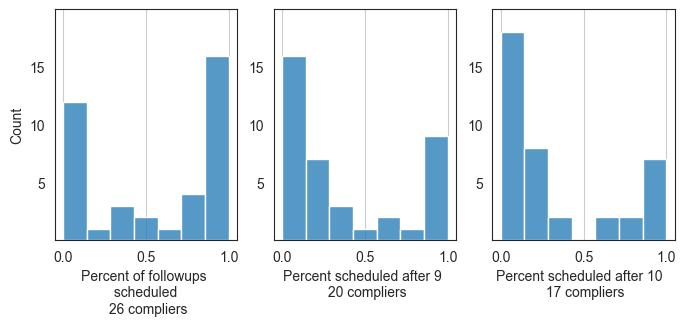

In [769]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1)

sns.histplot(first_last_cons.query("treatment == 1"),
                x="pct_scheduled")
plt.ylim([0,20])
plt.yticks([5,10,15])
plt.grid(axis='x')
plt.xlabel("Percent of followups \n scheduled \n 26 compliers")

plt.subplot(1, 3, 2)
sns.histplot(first_last_cons.query("treatment == 1"),
                x="sched_9")
plt.ylabel("")
plt.ylim([0,20])
plt.yticks([5,10,15])
plt.grid(axis='x')
plt.xlabel("Percent scheduled after 9 \n 20 compliers")

plt.subplot(1, 3, 3)
sns.histplot(first_last_cons.query("treatment == 1"),
                x="sched_10")
plt.ylabel("")
plt.ylim([0,20])
plt.yticks([5,10,15])
plt.grid(axis='x')
plt.xlabel("Percent scheduled after 10  \n 17 compliers")

plt.show()

In [642]:
first_last_cons.query("treatment == 1 & complier == 1")["facility"].unique()

array([ 2,  4,  6,  8, 10, 12, 18, 20, 22, 28, 30, 32, 34, 36, 38, 40, 42,
       44, 50, 52, 54, 60, 66, 68, 70, 76, 78])

In [644]:
first_last_cons.query("treatment == 1 & sched_9 >= 0.2")["facility"].unique()

array([ 2,  6,  8, 12, 18, 20, 22, 30, 32, 34, 36, 38, 40, 42, 44, 50, 52,
       54, 66, 76])

In [645]:
first_last_cons.query("treatment == 1 & sched_10 >= 0.2")["facility"].unique()

array([ 2,  6,  8, 12, 20, 22, 30, 32, 34, 36, 38, 40, 42, 44, 50, 52, 76])

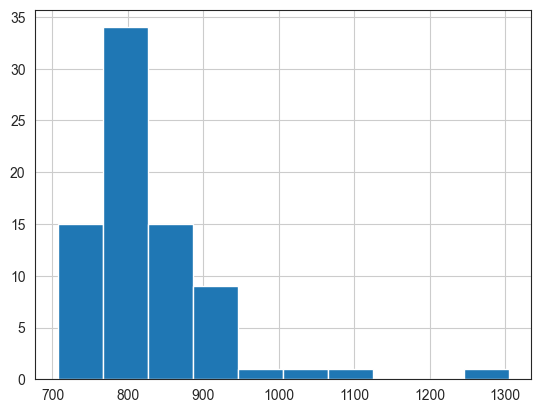

In [527]:
anc.groupby(["facility"])["time_entered"].first().hist()
plt.show()

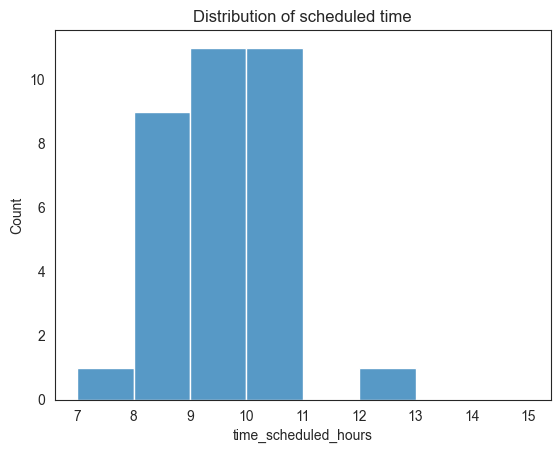

In [516]:
sns.histplot(first_last_cons,
             x="time_scheduled_hours",
             stat="count", bins=range(7,16), common_norm=False)
plt.title("Distribution of scheduled time")
plt.show()

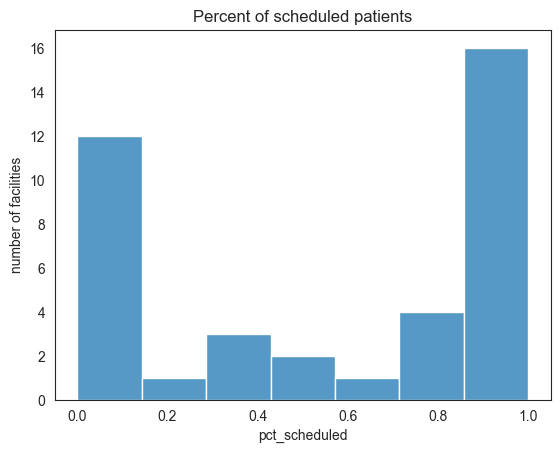

In [474]:
# dist percent scheduled

sns.histplot(first_last_cons.query("treatment == 1"),
             x="pct_scheduled",
             stat="count")
plt.title("Percent of scheduled patients")
plt.ylabel("number of facilities")
plt.show()

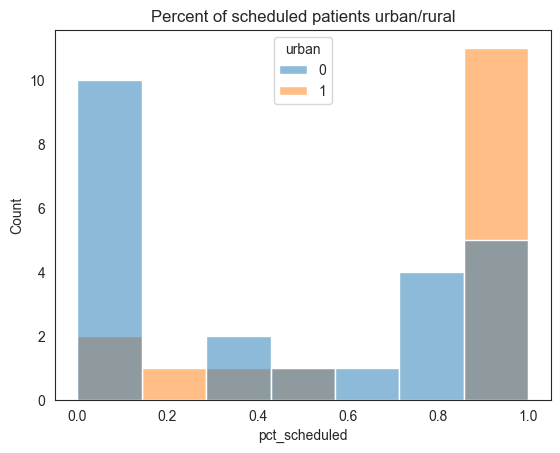

In [469]:
# dist percent scheduled after 10

sns.histplot(first_last_cons.query("treatment == 1"),
             x="pct_scheduled",
             stat="count", hue="urban", common_norm=False)
plt.title("Percent of scheduled patients urban/rural")
plt.ylabel("number of facilities")
plt.show()

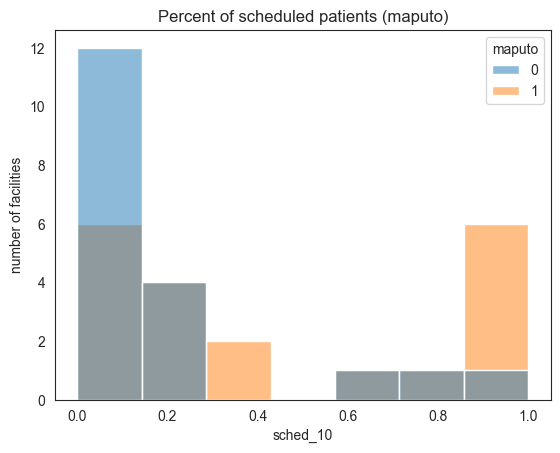

In [771]:
sns.histplot(first_last_cons.query("treatment == 1"),
             x="sched_10",
             stat="count", hue="maputo", common_norm=False)
plt.title("Percent of scheduled patients (maputo)")
plt.ylabel("number of facilities")
plt.show()

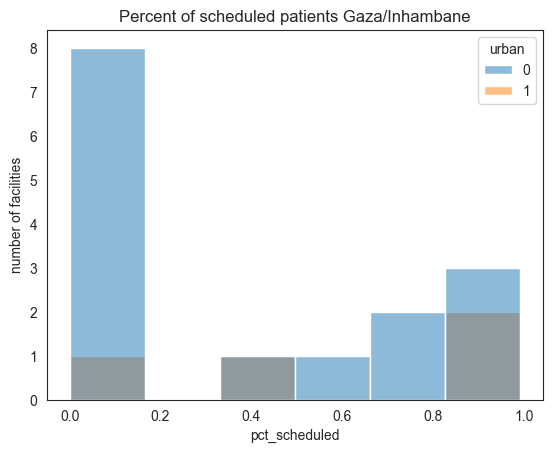

In [477]:
sns.histplot(first_last_cons.query("treatment == 1 & maputo == 0"),
             x="pct_scheduled",
             stat="count", hue="urban", common_norm=False)
plt.title("Percent of scheduled patients Gaza/Inhambane")
plt.ylabel("number of facilities")
plt.show()

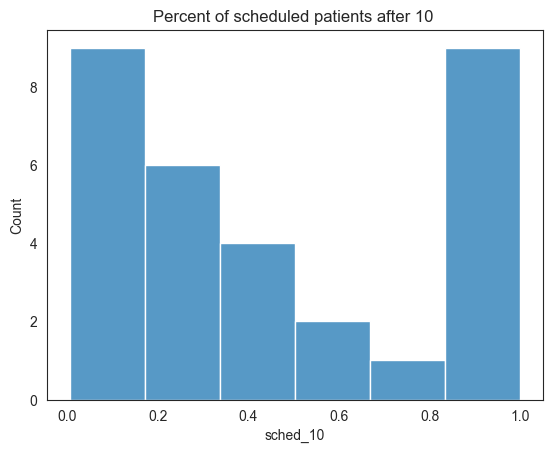

In [529]:
sns.histplot(first_last_cons.query("treatment == 1 & sched_10 > 0"),
             x="sched_10",
             stat="count")
plt.title("Percent of scheduled patients after 10 ")
plt.show()



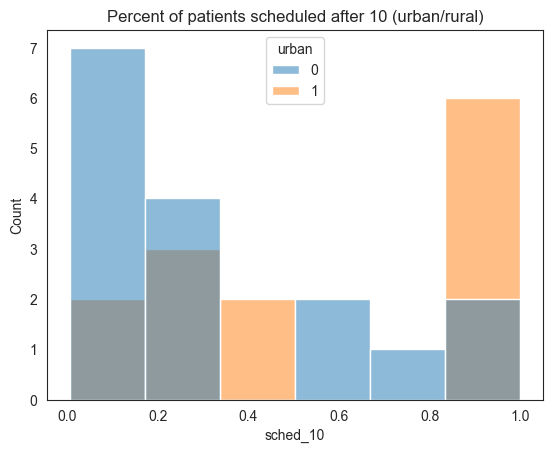

In [524]:

sns.histplot(first_last_cons.query("treatment == 1 & sched_10 > 0"),
             x="sched_10",
             stat="count", hue="urban", common_norm=False)
plt.title("Percent of patients scheduled after 10 (urban/rural)")
plt.show()


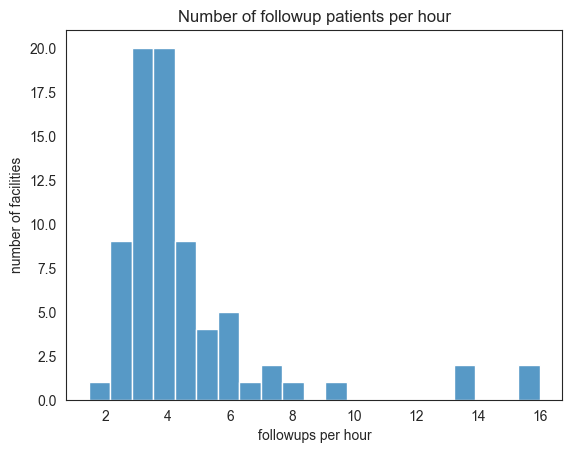

In [482]:
sns.histplot(first_last_cons,
             x="followup_per_hour",
             stat="count", )
plt.title("Number of followup patients per hour")
plt.ylabel("number of facilities")
plt.xlabel("followups per hour")
plt.show()

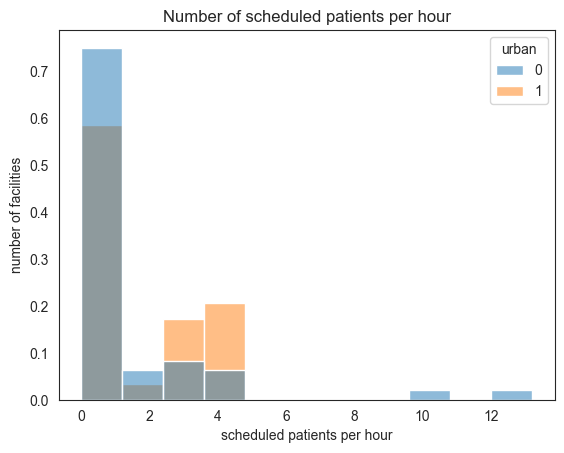

In [483]:
sns.histplot(first_last_cons,
             x="scheduled_per_hour",
             stat="probability", hue="urban", common_norm=False)
plt.title("Number of scheduled patients per hour")
plt.ylabel("number of facilities")
plt.xlabel("scheduled patients per hour")
plt.show()

In [520]:
first_last_cons.query("pct_scheduled > 0.2").shape

(26, 127)

In [521]:
first_last_cons.query("scheduled_per_hour <= 5 & pct_scheduled > 0.2").shape


(24, 127)

In [530]:
first_last_cons.query("scheduled_per_hour <= 5 & sched_10 > 0.2").shape

(18, 127)

In [578]:
first_last_cons["lost"] = 0
q_lost = first_last_cons.eval("pct_scheduled >= 0.2 & sched_10 <= 0.2")
first_last_cons.loc[q_lost, "lost"] = 1

In [577]:
first_last_cons[["facility", "complier", "pct_scheduled", 
                 "sched_9", "sched_10", "lost"]]

# Lose: 4, 10, 18, 60

18: had schedules at 8, 9, 10


,facility,complier,pct_scheduled,sched_9,sched_10,lost
0,1,0.0,0.000000,0.000000,0.000000,0
1,2,1.0,0.940594,0.455196,0.348678,0
2,3,0.0,0.000000,0.000000,0.000000,0
3,4,1.0,1.000000,0.000000,0.000000,1
4,5,1.0,0.000000,0.000000,0.000000,0
5,6,1.0,1.000000,0.281966,0.273424,0
6,7,0.0,0.000000,0.000000,0.000000,0
7,8,1.0,1.000000,1.000000,1.000000,0
8,9,0.0,0.000000,0.000000,0.000000,0
9,10,1.0,0.323864,0.152763,0.126374,1


In [594]:
first_last_cons.query("lost == 1")[["facility", "complier", "pct_scheduled", 
                 "sched_9", "sched_10", "lost"]]

,facility,complier,pct_scheduled,sched_9,sched_10,lost
3,4,1.0,1.000000,0.000000,0.000000,1
9,10,1.0,0.323864,0.152763,0.126374,1
16,18,1.0,0.810345,0.745601,0.177244,1
23,28,1.0,0.325581,0.103463,0.000000,1
48,54,1.0,0.422764,0.250159,0.145982,1
54,60,1.0,0.918919,0.000000,0.000000,1
60,66,1.0,0.432990,0.274272,0.187004,1
64,70,1.0,0.961905,0.184581,0.062817,1
72,78,1.0,0.854545,0.060516,0.032738,1


In [808]:
first_appoint = (anc.groupby(["facility_cod", "treatment", "day"])
                    ["time_entered"].first()
                    .reset_index())
first_appoint["time_entered_float"] = (first_appoint["time_entered"]
                                        .apply(time_to_time_float))

In [833]:
first_last_cons

,facility_cod,day,time_entered_x,time_entered_y,scheduled,followup,sched_9,sched_10,time_scheduled_hours,hours_followup,...,daily_lectures_art,date_completion,distance_district_minutes,cd4_mesma_us,hemograma_mesma_us,has_lab_num,has_reception_num,maputo,distance_to_maputo,pct_scheduled
0,1,6.909091,843.545455,1122.545455,0.000000,23.181818,0.000000,0.000000,NaN,2.831818,...,sim,,NaN,1.0,0.0,1.0,1.0,1,4.0,0.000000
1,2,6.000000,902.363636,1170.272727,8.818182,9.363636,0.928058,0.928058,919.418367,2.707576,...,sim,,45.00,1.0,0.0,0.0,1.0,1,9.0,0.941748
2,3,6.500000,846.083333,1267.583333,0.000000,24.583333,0.000000,0.000000,NaN,4.247222,...,sim,,4.50,0.0,0.0,1.0,1.0,1,12.0,0.000000
3,4,7.200000,835.900000,1123.900000,6.400000,6.400000,1.000000,1.000000,830.000000,2.866667,...,sim,,10.00,0.0,1.0,1.0,1.0,1,3.0,1.000000
4,5,6.636364,745.181818,1186.636364,0.000000,23.454545,0.000000,0.000000,NaN,4.387879,...,sim,,30.00,0.0,0.0,1.0,1.0,1,2.0,0.000000
5,6,6.500000,805.833333,1363.333333,15.666667,15.666667,1.000000,1.000000,849.872340,5.569444,...,sim,,30.00,0.0,0.0,1.0,1.0,1,1.0,1.000000
6,7,6.909091,906.181818,1161.636364,0.000000,8.363636,0.000000,0.000000,NaN,2.560606,...,sim,,60.00,1.0,0.0,1.0,1.0,1,9.0,0.000000
7,8,6.500000,921.000000,1236.500000,12.250000,12.250000,1.000000,1.000000,1000.680272,3.147222,...,sim,,30.00,0.0,0.0,1.0,1.0,1,10.0,1.000000
8,9,6.500000,874.416667,1092.083333,0.000000,7.750000,0.000000,0.000000,NaN,2.238889,...,,,NaN,NaN,NaN,NaN,NaN,1,2.0,0.000000
9,10,6.500000,855.083333,1267.916667,5.000000,15.166667,0.341178,0.341178,1121.583333,4.158333,...,sim,,10.00,0.0,0.0,1.0,1.0,1,6.0,0.329670


In [832]:
first_appoint = first_appoint
first_appoint.groupby(["facility_cod", "day"])

,facility_cod,treatment,day,time_entered,time_entered_float
0,1,0,1,707,7.12
2,1,0,4,744,7.73
1,1,0,3,755,7.92
4,1,0,6,801,8.02
9,1,0,11,805,8.08
...,...,...,...,...,...
885,83,0,1,806,8.10
892,83,0,10,825,8.42
891,83,0,8,830,8.50
888,83,0,4,850,8.83


In [537]:
import numpy as np
def time_to_time_float(time):
    """ transforms 730 into 7.5 """
    if not time:
        return np.nan
    if time == "":
        return np.nan
    if len(str(time)) < 3:
        return np.nan

    time = str(time)
    size = len(time)
    hour = float(time[0:(size-2)])
    minute = float(time[(size-2):size])
    return hour + round(minute/60, 2)

In [739]:
anc_merged = anc.merge(anc[["facility_cod", "us_id", "time_scheduled_cleaned"]], 
                       on=["facility_cod", "us_id"], how="left",
                       indicator=True)
anc_merged = anc_merged[["facility_cod", "us_id", "time_scheduled_cleaned_x",
                         "time_scheduled_cleaned_y", "_merge"]]

anc_merged.query("_merge == 'left_only'")

anc_merged["time_scheduled_cleaned_x"] == np.nan

final_only = anc_merged.eval(" _merge == 'left_only' ")
both = anc_merged.eval(" _merge == 'both' ")

anc_merged.loc[final_only, "time_scheduled_cleaned"] = anc_merged["time_scheduled_cleaned_x"]
anc_merged.loc[both, "time_scheduled_cleaned"] = anc_merged["time_scheduled_cleaned_y"]

In [742]:

(anc_merged[["facility_cod", "us_id", "time_scheduled_cleaned"]]
    .to_csv(f"{AUX}/time_scheduled_cleaned.csv", index=False))

In [756]:
anc_merged = anc_merged[["facility_cod", "us_id", "time_scheduled_cleaned"]]


In [765]:
def time_to_time_float(time):
    """ transforms 730 into 7.5 """
    if not time:
        return np.nan
    if time == "":
        return np.nan
    if len(str(time)) < 3:
        return np.nan

    time = str(time)
    size = len(time)
    hour = float(time[0:(size-2)])
    minute = float(time[(size-2):size])
    return hour + round(minute/60, 2)

In [ ]:
final = final[(final["time_arrived"].astype(str).str.len() > 2) &
        (final["time_arrived"].astype(str).str.len() < 5)]
final = final[(final["time_entered"].astype(str).str.len() > 2) &
        (final["time_entered"].astype(str).str.len() < 5)]
final = final[(final["time_left"].astype(str).str.len() > 2) &
        (final["time_left"].astype(str).str.len() < 5)]

final["waiting_time_temp"] = final["time_entered"] - final["time_arrived"]
final = final.query("waiting_time_temp >= 0")

final = final[final["time_arrived"] >= 600]
final = final[final["time_entered"] <= 1600]
final = final[final["time_left"] <= 1600]

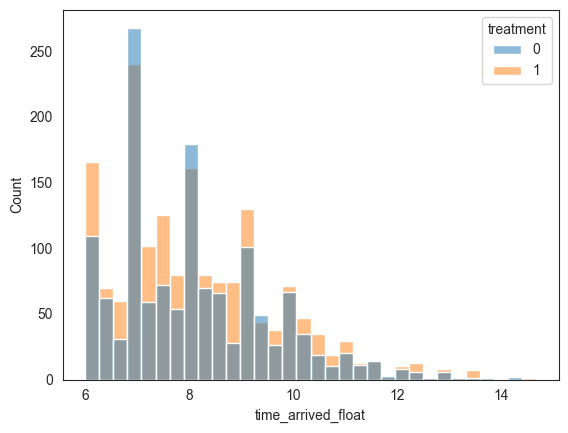

In [961]:
sns.histplot(anc.query("consultation_reason == 1"),
             x="time_arrived_float", hue="treatment")
plt.show()

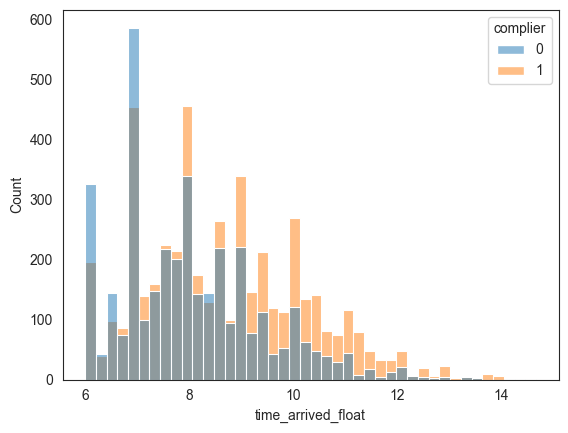

In [963]:
sns.histplot(anc.query("consultation_reason == 2"),
             x="time_arrived_float", hue="complier")
plt.show()

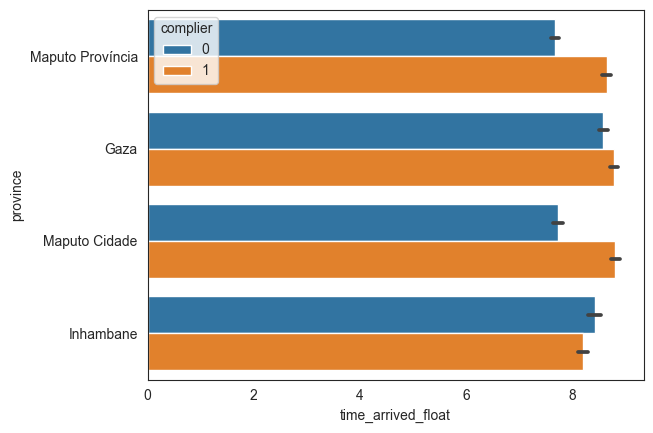

In [971]:
sns.barplot(anc.query("consultation_reason == 2"),
             x="time_arrived_float", y="province", hue="complier")
plt.show()

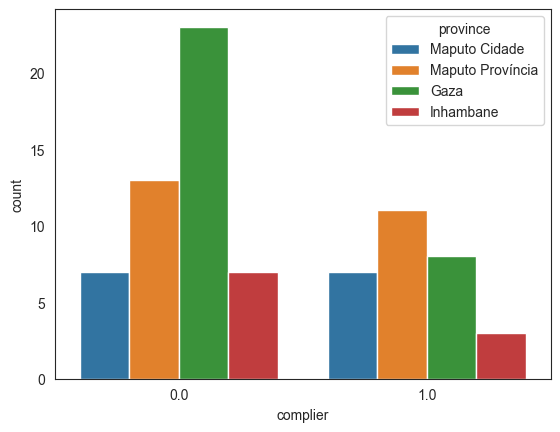

In [974]:
sns.countplot(facility_characteristics, x="complier", hue="province")
plt.show()

In [983]:
facility_characteristics.groupby(["province", "treatment"]).size()

province          treatment
Gaza              0            17
                  1            14
Inhambane         0             5
                  1             5
Maputo Cidade     0             6
                  1             8
Maputo Província  0            12
                  1            13
dtype: int64

In [991]:
(anc.query("province == 'Gaza' & consultation_reason == 2")
    .groupby("complier10")
    .agg({"time_arrived_float":["mean", "std"]}))

time_arrived_float          
                         mean       std
complier10                             
0                    8.467647  1.364416
1                    9.252453  1.524527

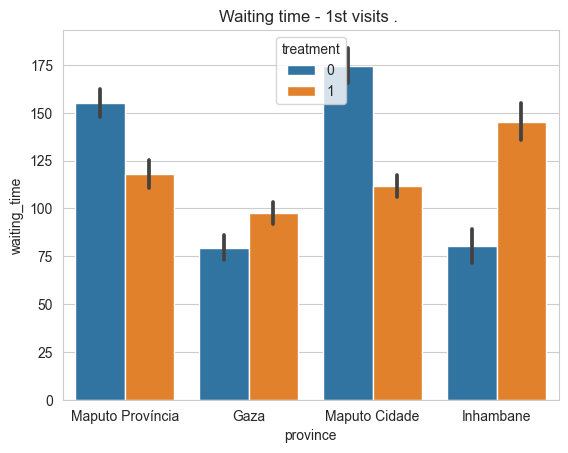

In [1014]:
sns.set_style("whitegrid")
sns.barplot(anc.query("consultation_reason == 1"),
            x="province", y="waiting_time",
            hue="treatment")
plt.title("Waiting time - 1st visits . ")
plt.savefig(f"{ROOT}/../graphs/waiting_time_by_province.png", bbox_inches='tight',dpi=300)
plt.show()

In [1177]:
pd.set_option('display.max_rows', 2000)

exit_interview = pd.read_stata(f"{ROOT}/cleaned_data/anc_exit_interview_cleaned.dta")
exit_interview = exit_interview.merge(
    facility_characteristics[["facility_cod", "complier", "complier10", "urban", "maputo"]], 
    on="facility_cod")
exit_interview["transp_time_float"] = (exit_interview["transp_time"].str.replace("\n", "")
                                 .replace("\,", "", regex=True)
                                 .replace("\.", "", regex=True)
                                 .replace("\s+", "", regex=True)
                                 .str.strip()
                                 .str.lstrip("0")
                                 .str.lstrip(":")
                                 .apply(clean_timestring))

<ipython-input-1177-c51d77b9f74c>:3: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  exit_interview = pd.read_stata(f"{ROOT}/cleaned_data/anc_exit_interview_cleaned.dta")
<ipython-input-1177-c51d77b9f74c>:3: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  exit_interview = pd.read_stata(f"{ROOT}/cleaned_data/anc_exit_interview_cleaned.dta")
<ipython-input-1177-c51d77b9f74c>:3: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is b

<ipython-input-1177-c51d77b9f74c>:3: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  exit_interview = pd.read_stata(f"{ROOT}/cleaned_data/anc_exit_interview_cleaned.dta")
<ipython-input-1177-c51d77b9f74c>:3: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  exit_interview = pd.read_stata(f"{ROOT}/cleaned_data/anc_exit_interview_cleaned.dta")
<ipython-input-1177-c51d77b9f74c>:3: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is b

In [1127]:
def get_splitted_time(time, char):
    hour = int(time.split(char)[0])
    minute = int(time.split(char)[1])
    return hour*60 + minute

def clean_timestring(time):
    size=len(time)
    if size > 5 or size == 0:
        return np.nan

    result = np.nan
    if size == 1:
        if time == "1":
            return 60
        if time == "2":
            return 120
        if time == "3":
            return 180
        
        if int(time) >= 5:
            result = int(time)

    elif size == 2:
        if "h" in time :
            hour = int(time.split("h")[0])
            result = hour*60

        elif "H" in time:
            hour = int(time.split("H")[0])
            result = hour*60

        else:
            result = int(time)

    elif size == 3 or size == 4:
        if "h" in time :
            result = get_splitted_time(time, "h")

        elif "H" in time:
            result = get_splitted_time(time, "H")

        elif ":" in time:
            result = get_splitted_time(time, ":")
        else:
            result = int(time)

    return float(result)

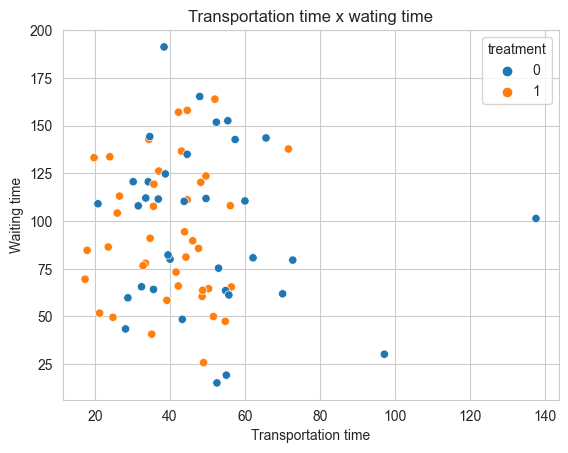

In [1186]:
#.query("urban == 0")
wt_fac = anc.groupby(["facility_cod", "treatment"])["waiting_time"].mean().reset_index()
transp_fac = exit_interview.groupby("facility_cod")["transp_time_float"].mean().reset_index()

wt_fac = wt_fac.merge(transp_fac, on="facility_cod")

sns.scatterplot(wt_fac, x="transp_time_float", y="waiting_time", 
                hue="treatment")
plt.ylabel("Waiting time")
plt.xlabel("Transportation time")
plt.title("Transportation time x wating time")
plt.show()

In [1162]:
np.corrcoef(wt_fac.query("urban == 0")["transp_time_float"],
            wt_fac.query("urban == 0")["waiting_time"])

array([[ 1.       , -0.1096747],
       [-0.1096747,  1.       ]])

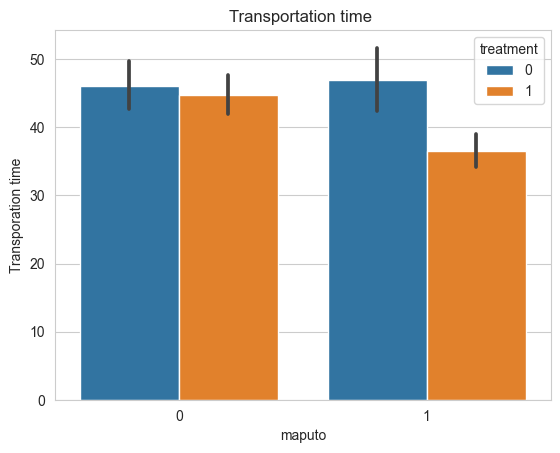

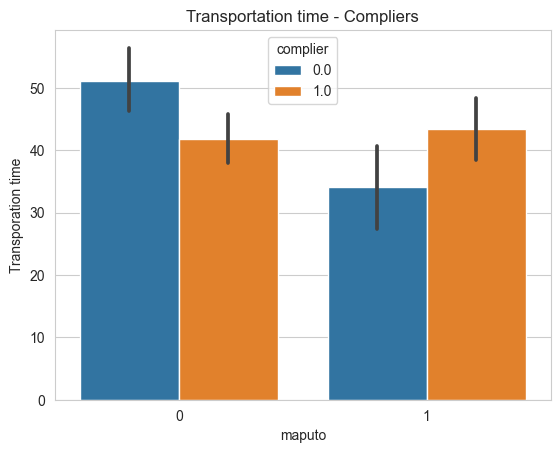

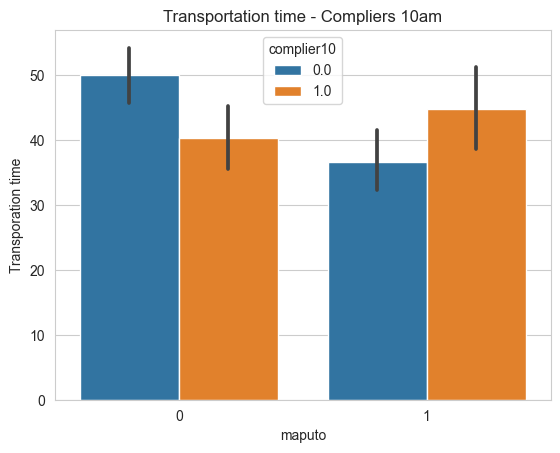

In [1176]:
subset = exit_interview

sns.set_style("whitegrid")
sns.barplot(subset,
            x="maputo", y="transp_time_float",
            hue="treatment", errorbar=("ci",95))
plt.title("Transportation time ")
plt.ylabel("Transporation time")
plt.show()

sns.set_style("whitegrid")
sns.barplot(subset.query("treatment == 1 & urban == 0"),
            x="maputo", y="transp_time_float",
            hue="complier", errorbar=("ci",95))
plt.title("Transportation time - Compliers")
plt.ylabel("Transporation time")
plt.show()

sns.set_style("whitegrid")
sns.barplot(subset.query("treatment == 1 & urban == 0"),
            x="maputo", y="transp_time_float",
            hue="complier10", errorbar=("ci",95))
plt.title("Transportation time - Compliers 10am")
plt.ylabel("Transporation time")
plt.show()


## Patient compliance

In [1182]:
[c for c in anc.columns if "sch" in c]

['time_scheduled_cleaned',
 'scheduled_mean_fac',
 'time_scheduled_hours',
 'scheduled_std',
 'sched_10']

In [1185]:
anc[["time_scheduled_cleaned", "time_scheduled_hours"]].query("time_scheduled_cleaned.notna()")

,time_scheduled_cleaned,time_scheduled_hours
150,1000.0,1000.0
151,800.0,800.0
152,1000.0,1000.0
155,900.0,900.0
157,800.0,800.0
...,...,...
14000,1100.0,1100.0
14001,1000.0,1000.0
14002,1000.0,1000.0
14003,1100.0,1100.0
